# A Data Analysis Project in Mortgage Credit Analysis

In [2]:
# import modules
import pandas as pd
import sqlalchemy as sa
import numpy as np

In [3]:
# To see plots in notebook, run the following command
%matplotlib inline

# Part 1. Connect to MySQL database.
sqlalchemy is used to create the connection.

In [4]:
host='***' # not showed here 
port='3306'
username='***'# not showed here
password='***'# not showed here
schema='AgencyData'
table='CleanFreddieSample'
dialect_driver='mysql+pymysql'
#use the above information to form a connection
connection=dialect_driver+'://'+username+':'+password+'@'+host+':'+port+'/'+schema
engine=sa.create_engine(connection)

In [5]:
# Use SQL command to get the data from database
sql='select * from '+table # remeber to add a space after from
data=pd.read_sql(sql,engine) # the mortgage data has the DataFrame structure
data.shape # you should see the mortgage data has 20,000 rows and 19 columns

(20000, 19)

# Part 2. Group the data by year
Analyze the breakdown of mortgage statuses and see how mortgage behavior changes 

In [7]:
# to group by year, add a new columns called year
data['year']=[n[0:4]for n in data['first_pmt_date']] # get first 4 digits as year

In [8]:
#use pivot_table function from DataFrame to groupd the data
# If some years don't have any record, the count should be 0 
data_group_by_year=data.pivot_table(index='year',columns='status',aggfunc='size',fill_value=0)

# show data_group_by_year structure. Year varies from 1999 to 2017
data_group_by_year 

status,Alive,Default,Prepay
year,,,
1999,15,5,731
2000,2,11,599
2001,27,32,1249
2002,59,28,1353
2003,132,41,1585
2004,108,28,788
2005,180,69,1112
2006,123,88,933
2007,101,100,799


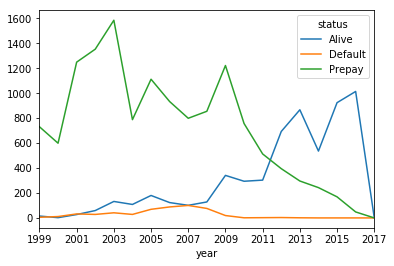

In [9]:
# plot the data
data_group_by_year.plot()

From the figure, we can see the number of Prepay increases first then drops
over years. The number of Alive is flat in the beginning and increases sharply
from year 2009. The number of Default is overall flat but in 2008, it has a significant jump 

# Part 3. Group the data by age

In [10]:
data_group_by_age=data.pivot_table(index='age',columns='status',aggfunc='size',fill_value=0)
# take a look at the head part of the data
data_group_by_age.head()

status,Alive,Default,Prepay
age,,,
-1.0,0,0,9
0.0,0,0,1
1.0,0,0,38
2.0,0,0,94
3.0,0,0,107


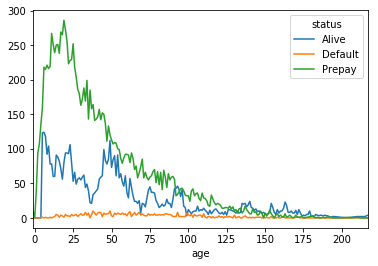

In [11]:
# plot the data
data_group_by_age.plot()

# Part 4. Caculate Probabilities
* That a mortgage has defaulted in the first 5 years
* That a mortgage has prepaid in the first 5 years, and
* That a mortgage is still alive after 5 years.

In [12]:
# first 5 years means first 60 months, or that the AGE is less than 60.
data_less_5years=data_group_by_age[data_group_by_age.index<60]

# dataframe sum funciton will sum up the values accross all rows for each column
num_alive,num_default,num_prepay=data_less_5years.sum()
print('alive, default, prepaid are {0},{1},{2}'.format(num_alive,num_default,num_prepay))
# caclute the probabilities

alive, default, prepaid are 3868,231,10249


In [13]:
# caculate the probability
p_default=num_default/(num_alive+num_default+num_prepay)
p_prepay=num_prepay/(num_alive+num_default+num_prepay)
p_alive=num_alive/(num_alive+num_default+num_prepay)
# print the result and keep results with four digits
print('the default probability in first 5 years is {:.4f}'.format(p_default))
print('the prepaid probability in first 5 years is {:.4f}'.format(p_prepay))
print('the probability a mortgage alive after 5 years is {:.4f}'.format(p_alive))

the default probability in first 5 years is 0.0161
the prepaid probability in first 5 years is 0.7143
the probability a mortgage alive after 5 years is 0.2696


# Part 5. Use model to predict status
In the following code, AGE is selected as the factor to predict the default rate.
As this is a classification problem, a maching learning method Decision Tree is
used to build the model

The most popular machine learning module in Python is scikit-learn.
You will need import modules fisrt to utilize those functions

In [14]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Build model

In [15]:
#Use X to stand for factor and y to stand for dependent variable.
y=data['status'].values # use .values to get the numpy ndarray data type
X=data['age'].values.reshape(-1,1)# reshape will convert the array to two dimension,
# which is required data structure in the machine learning method

In [16]:
#There are in total 3 different statuses: DEFAULT, ALIVE and PREPAY. Our goal 
#is to analyze how DEFAULT responds to the factor AGE,so we can convert ALIVE
#and PREPAY to NOT_DEFAULT first
y=[v if v=='Default' else 'Not_Default'for v in y] 

In [17]:
# randomly split the data, 80% to train set and 20% to test set. Pick up a random state too
X_trainset, X_testset, y_trainset, y_testset=train_test_split(X,y,test_size=0.2,random_state=3)

# build a Decision Tree. The criterion used is 'entropy', 
# and max_depth is set to 2 to make the tree easier to understand
status_tree=DecisionTreeClassifier(criterion='entropy',max_depth=2)
status_tree.fit(X_trainset,y_trainset)# train the tree
status_predset=status_tree.predict(X_testset) # precict the test data 

Evaluate the model

In [18]:
from sklearn import metrics
# use confusion matrix to evaluate the accuracy
conf_matrix=metrics.confusion_matrix(y_testset, status_predset,labels=['Not_Default','Default'])

In [19]:
print(conf_matrix)

[[3887    0]
 [ 113    0]]


In [20]:
true_not_default=conf_matrix[0,0]
false_not_default=conf_matrix[1,0]
true_default=conf_matrix[1,1]
false_default=conf_matrix[0,1]
true_defaut_ratio=true_default/(true_default+false_not_default)
true_not_default_ratio=true_not_default/(true_not_default+false_default)
accuracy_rate=(true_default+true_not_default)/len(y_testset)
print('true default rate is {}'.format(true_defaut_ratio))
print('true not default rate is {}'.format(true_not_default_ratio))
print('accuracy rate is {}'. format(accuracy_rate))

true default rate is 0.0
true not default rate is 1.0
accuracy rate is 0.97175


In [21]:
# compare the model to null accuracy
# null accuracy: accuracy by always predicting the most frequent status,
# in this case, always predict result as NOT DEFAULT
null_accuracy=y_testset.count('Not_Default')/len(y_testset) 
print('null accuracy is {}'.format(null_accuracy))

null accuracy is 0.97175


The result shows that the model can predict the true NOT DEFAULT 100% correctly, however it cannot predict the DEFAULT status. The reason is that the default status accounts for a very small proportion of the sample data. Using majority vote, the model would vote all situations to NOT DEFAULT. (one way to solve this issue is using upsampling, which is not used here)

As well, the model has the same accuracy rate to null accuracy. 

Then, is the model still useful? Yes, it is. The decision tree can show how the model works

Visualize the decision tree

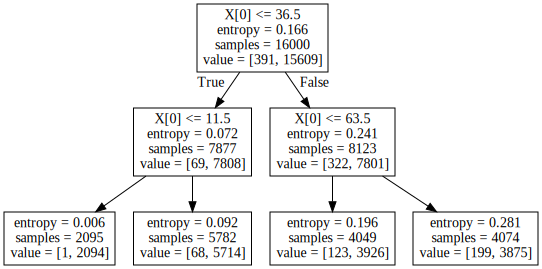

In [22]:
import graphviz
dot_data=tree.export_graphviz(status_tree)
graph=graphviz.Source(dot_data)
graph